###     딥러닝 중간고사 대체과제

## SingleLayerNN을 활용하여 2-class classification
    - 2-class classification에 알맞은 데이터 셋을 사용하기(10점)
    - 데이터 exploring을 통해 나름의 분석을 할 것(10점)
    - 제출형식을 맞추어 제출할 것(10점)
    - 문제정의(300자 이내), 결과분석 및 결론(300자 이내)를 기술할 것(30점)
    - SingleLayerNN 모델의 메소드들을 적절히 사용(필요한 경우 수정, 단 수정한 경우 수정한 이유와 결과를 주석으로 표기)하여 모델의 정확도를 최대한 높일 것(40점)

# Dataset Import
    해당 데이터셋은 Kaggle에 있는 데이터셋을 활용하였습니다.
    https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset
    
    해당 데이터셋은 310명에 대해 13개의 특성을 측정한 것입니다.
    그중 한개의 특성은 정상인지 비정상인지에 대한 데이터입니다.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("./Dataset_spine.csv", header = 0).dropna(axis=1)
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


### 다음은 각 피처에 대한 설명입니다.
    Col1 = pelvic incidence(골반 입사각)
    Col2 = pevic tilt(골반 전방경사)
    Col3 = lumbar lordosis angle(요추전만 각도)
    Col4 = sacral slope(천추 경사)
    Col5 = pelvic radius(골반 반경)
    Col6 = degree spondylolisthesis(척추전만전위증 정도)
    Col7 = pelvic slope(골반 경사)
    Col8 = direct tilt
    Col9 = thoracic slope(흉부 경사)
    Col10 = cervical tilt(자궁경부 경사)
    Col11 = sacrum angle(천추 각도)
    Col12 = scoliosis slope(척추 측만 각도)
    Class_att = Abnormal or Normal(비정상 / 정상)
    
    현재 해결하려는 문제를 정의하고자 합니다. lower back pain(허리통증)은 많은 사람들이 느끼는 질병입니다. 허리통증은 여러가지 요인으로 인하여 발생합니다. 그리고 모든 사람에게 발생될 수 있는 흔한 질병입니다. 일부 허리 통증은 그냥 넘어가도 되지만, 어떤 허리 통증은 넘어가면 안될 정도로 심각한 허리 통증일 수 있습니다.  
    이 데이터셋은 위의 설명한 12가치 피처가 존재합니다. 해당 피처를 활용하여 허리통증이 정상적인 수준일지 비정상적인 수준일지 판별하는 것을 통해 문제를 해결하고자 하였습니다.

## 데이터셋 분포
    Data Exploring을 해주었습니다

Normal 개수 : 100
Abnormal 개수 : 210


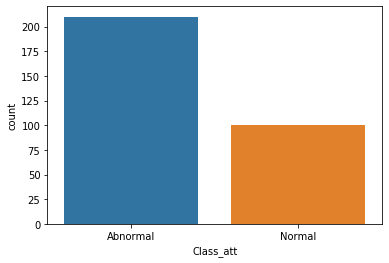

In [2]:
# !pip install seaborn
import seaborn as sns 
sns.countplot(df["Class_att"])
count_normal = list(df["Class_att"]).count("Normal")
count_abnormal = list(df["Class_att"]).count("Abnormal")
print(f"Normal 개수 : {count_normal}")
print(f"Abnormal 개수 : {count_abnormal}")

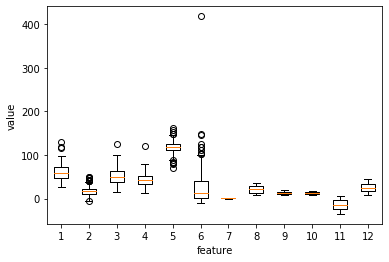

In [3]:
import matplotlib.pyplot as plt

plt.boxplot(df.drop(["Class_att"], axis = 1).iloc[:, :12].T)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

각 항목의 분포이다. 정규화를 해주지 않았기 때문에, 범위의 차이가 매우 큰 것을 알 수 있다.

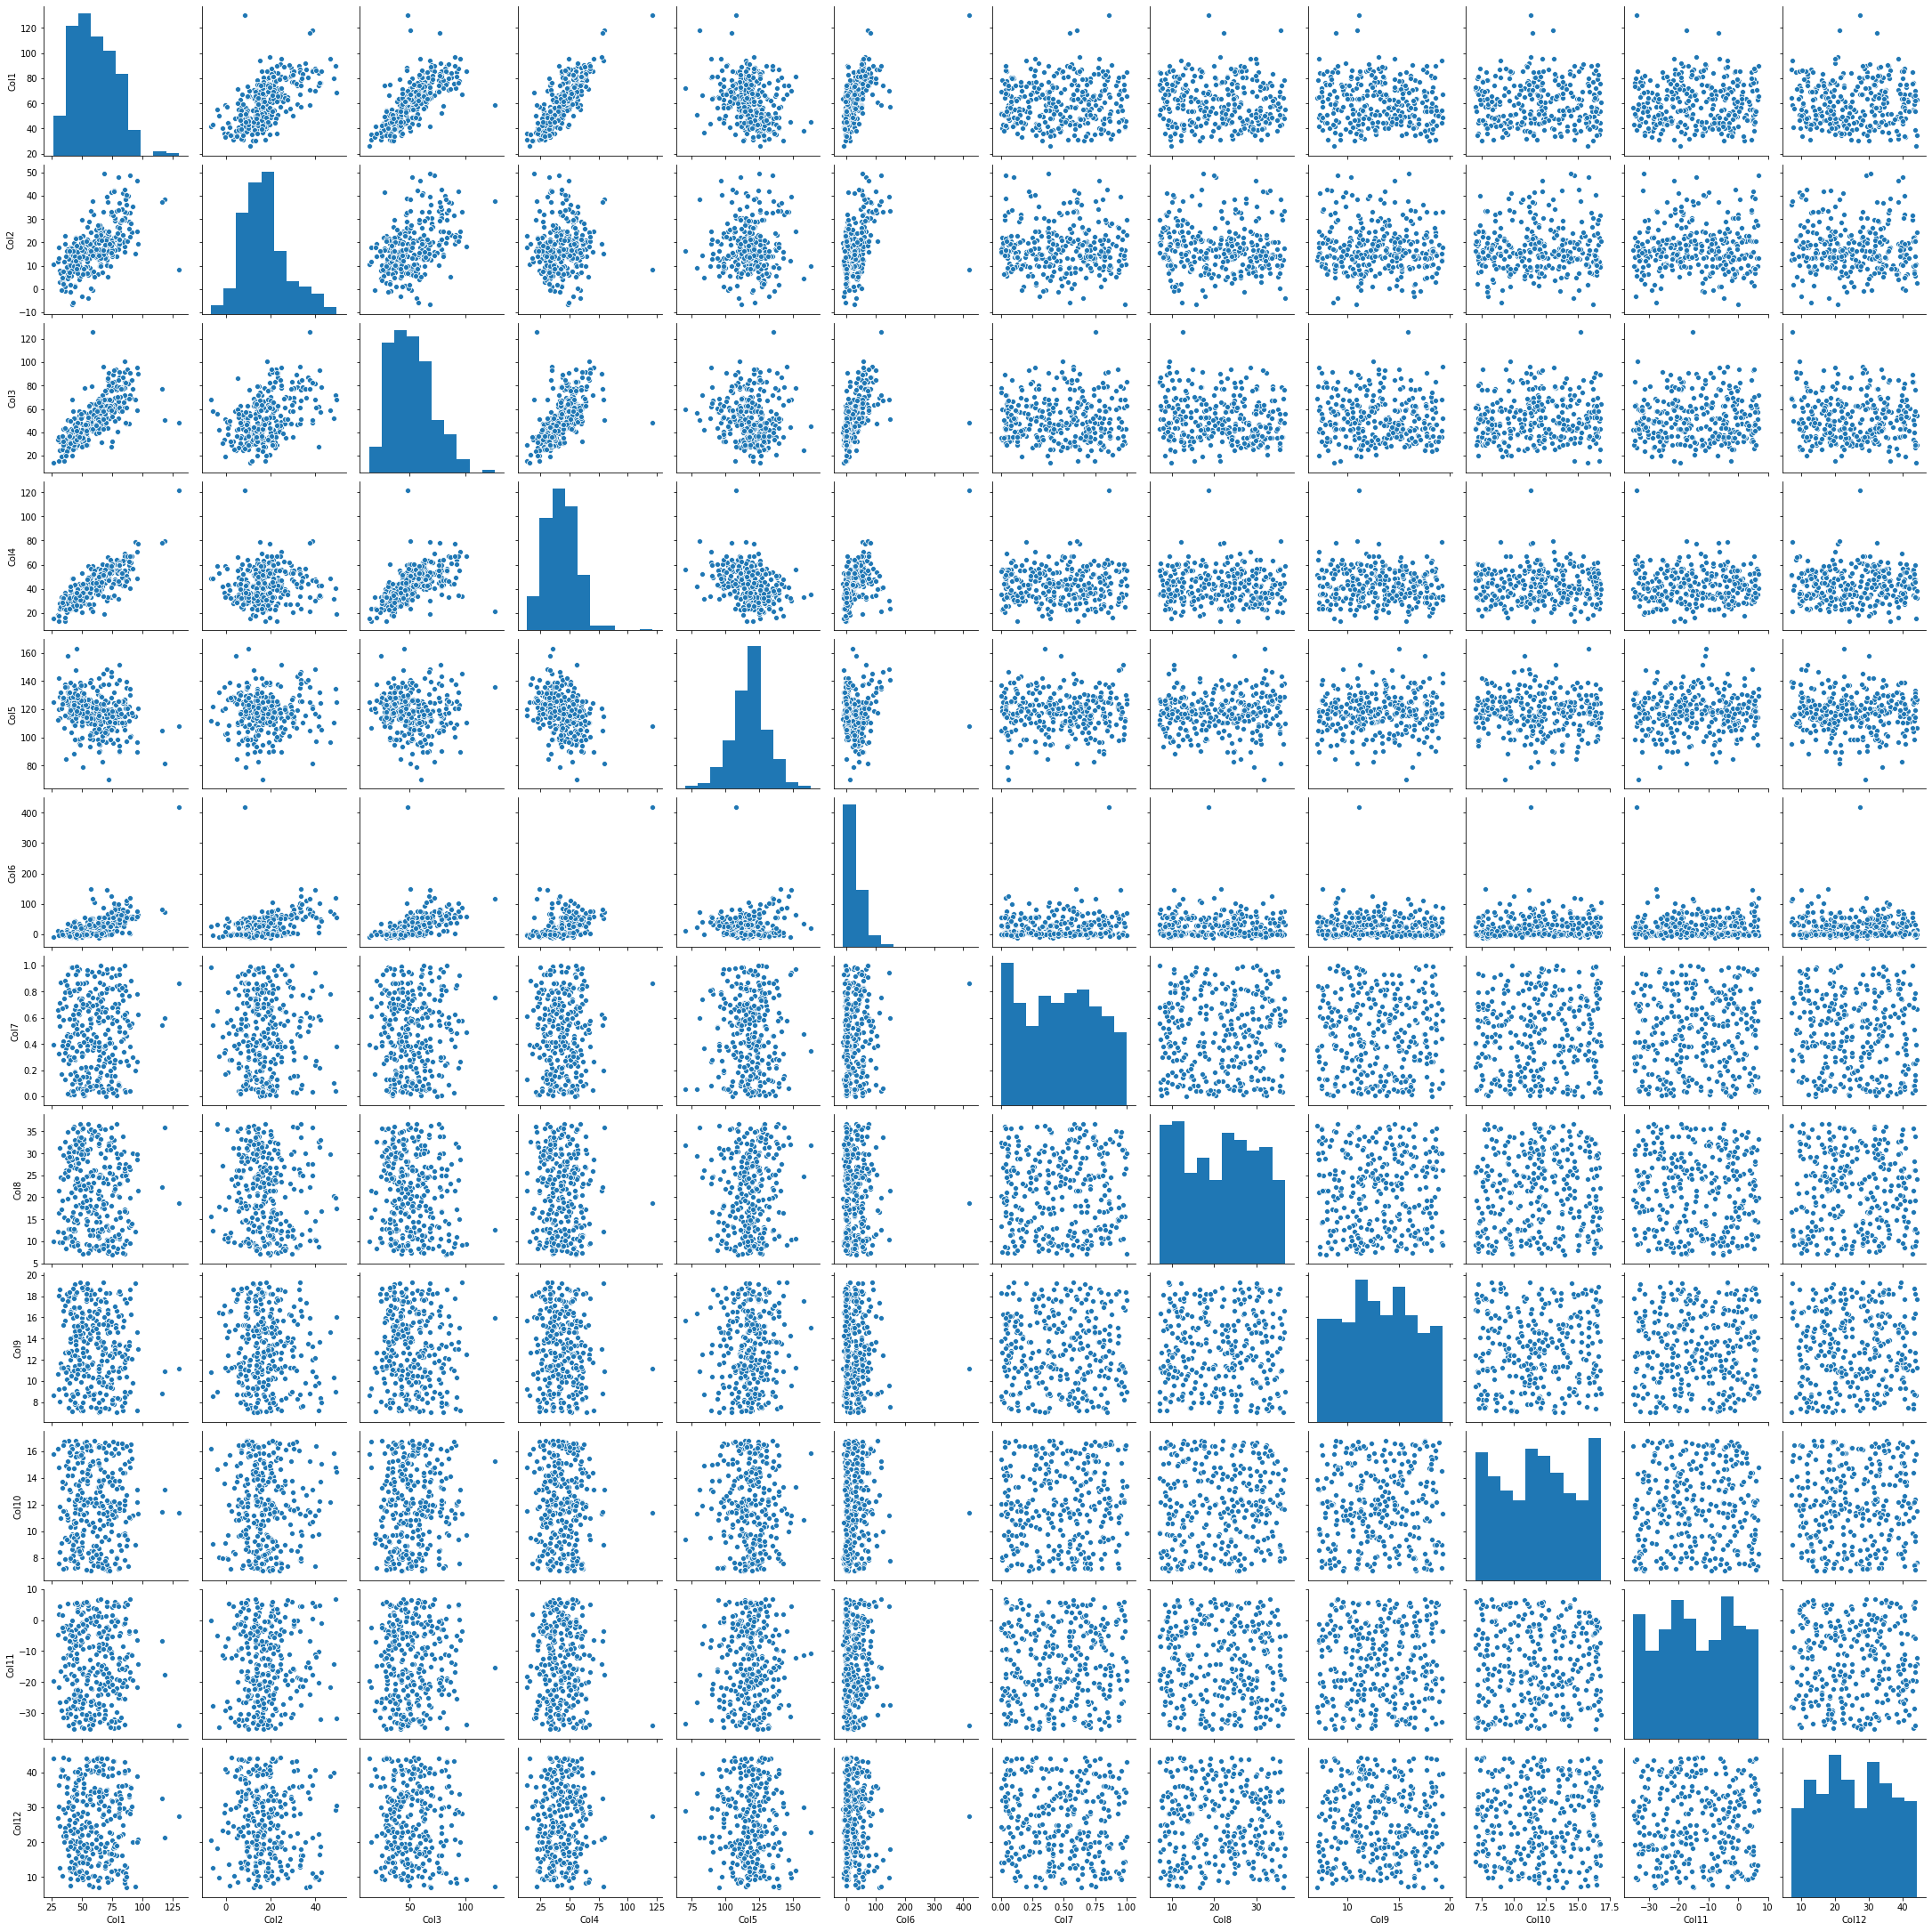

In [4]:
import seaborn as sns
sns.pairplot(df.drop(["Class_att"], axis = 1))

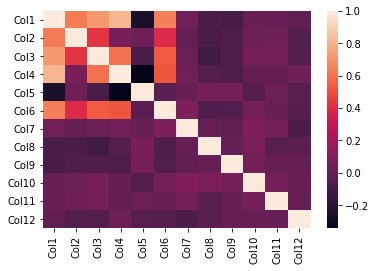

In [33]:
corr = df.drop(["Class_att"], axis = 1).corr()

sns.heatmap(corr)

데이터셋의 분포를 살펴볼 수 있다.
몇몇 데이터는 정규분포의 모양을 띈다. 또한, 몇몇 데이터는 서로 연관된(positive, negative)관계를 가지는 반면 전혀 관계가 없는 데이터 역시 존재한다.

# 사용하려는 함수 모음

## 1) Visualize를 위해서 사용한 함수들입니다.
    0. learning_curve - 교수님께서 알려주신 learning_curve그리는 것을 함수화했습니다.
    1. visualize_confusion_matrix - Confusion Matrix를 시각화하여 표현하기 위한 함수입니다.
    2. smooth_curve - learning curve가 너무 물결쳐서 확인이 어렵기 때문에, 이를 부드럽게 하기 위해서 쓴 함수입니다.

In [5]:
def learning_curve(loss, val_loss, smoothing = True, name = None):
    import matplotlib.pyplot as plt
    if smoothing:
        plt.plot(smooth_curve(loss))
        plt.plot(smooth_curve(val_loss))
    else:
        plt.plot((loss))
        plt.plot((val_loss))
    
    if name != None:
        plt.title(name)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'val_loss'])
    plt.show()

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
def visualize_matrix(y_true, y_pred, label = ["Normal", "Abnormal"]):
    import matplotlib.pyplot as plt
    print(classification_report(y_true, y_pred, target_names= label))
    data = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    data = pd.DataFrame(data, columns = label, index = label)
    fig = sns.heatmap(data = data, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues', annot_kws={"size": 10})
    fig.get_figure()
    plt.show()

In [7]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

## 2) 수업시간에 배운 SingleLayerNN입니다.

    여기에 약간 수정을 하였습니다.
    초기값의 경우, np.ones()를 하게 되면 전부 1로 w를 시작하게 됩니다.
    그러나, 초기값 세팅을 조금만 수정해도 성능이 좋아질 수 있음을 여러 검색을 통하여 확인하였습니다.
    
    그러므로 초기값을 다르게 세팅하여 성능을 올리고자 하였습니다.
    아래의 수식을 참고하여 초기값을 세팅을 해주었습니다.
    그리고, 매 실행마다 랜덤하게 다른 초기값이 세팅되어 성능이 변화할 수 있는 문제를 해결하기 위하여 
    np.random.seed(0)으로 설정해주었습니다.    
    
    
$$ w = U\begin{bmatrix}
- \frac{1}{\sqrt{n}} , \frac{1}{\sqrt{n}}\\
\end{bmatrix}$$

$$w = \text{weight}$$
$$U = \text{Uniform distribution}$$
$$n = \text{the size of the previous layer}$$

[참고사이트](https://reniew.github.io/13/)

이에 대한 실험은 (BL1-번외)에 진행되어 있습니다.



In [8]:
import numpy as np
from scipy.stats import norm

class SingleLayerNN:
    def __init__(self, learning_rate=.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def fwpass(self, x):
        z = np.sum(x*self.w) + self.b
        return z

    def bwpass(self, x, err):
        w_grad = x*err
        b_grad = 1*err
        return w_grad, b_grad

    def activation(self, z):
        #  z = np.clip(z, -100, None)
        a = 1 / (1+np.exp(-z))
        return a


    def fit(self, x, y, epochs=100, x_val=None, y_val=None, initialize = None):
        if initialize == "Ones":
            self.w = np.ones(x.shape[1]) #실험을 위해 initialize파라미터를 Ones로 할 경우, 가중치 초기값을 1로 세팅하도록 함
        else:
            np.random.seed(0)
            self.w =  np.random.uniform(-1/np.sqrt(x.shape[1]), 1/np.sqrt(x.shape[1]), x.shape[1]) 
            #아무 초기값에 대한 설정이 없을 경우 위에 수식에 따라서 초기화를 하도록 했다.
    
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(0) 
        for i in range(epochs):
#             print(f"Now {i+1} epoch of {epochs} epoch")
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in (indexes):
                z = self.fwpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.bwpass(x[i], err)
                w_grad += self.l1*np.sign(self.w)+self.l2*self.w
                self.w -= self.lr*w_grad
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 cliping 한 후 loss를 누적함
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
            self.update_val_loss(x_val, y_val)

    def predict(self, x):
        z = [self.fwpass(x_i) for x_i in x]
        a = self.activation(np.array(z))
        return a > 0.5

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.fwpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

    def reg_loss(self):
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)
    
    
    def set_params(self, learning_rate=.1, l1=0, l2=0):
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
    
    def get_params(self, deep = True):
        params = {"l1": self.l1, "l2":self.l2, "learning_rate":self.lr}
        return params

## 3) cross_validation
    예시 코드는 마지막에 validation셋에 한번도 포함되지 않는 경우가 존재해서 (수식으로 인하여)
    모든 셋을 전부 validation 해볼 수 있게 직접 함수를 구성함
    
    cv횟수도 지정할 수 있고, epochs도 걸어서 에포크에 따라서 다른 성능도 체크할 수 있도록 하였다.
    그리고 mean이라는 파라미터를 주어서 평균을 보여줄지, 각 폴드별 성능을 보여줄지도 고를 수 있도록 하였다.

In [9]:
def myfunc_cross_validation(layer, x_all, y_all, epochs = 100, cv=5, mean = True, l1 = None, l2 = None):
    if x_all.shape[0] != y_all.shape[0]:
        return "x_all and y_all shape is different"
    
    fold_count = 0
    X_splited = []
    y_splited =[]
    fold_end = 0
    for i in range(cv):
        fold_start = fold_end
        if i != cv-1:
            fold_end += (int(len(x_all)/cv) + i%2)
        else:
            fold_end = len(x_all)
        
        X_splited.append(x_all[fold_start:fold_end])
        y_splited.append(y_all[fold_start:fold_end])
    
    total = []
    for i in range(cv):
        x_val, y_val = X_splited[i], y_splited[i]
        x_train, y_train = np.concatenate([X_splited[j] for j in range(cv) if j != i], axis=0), np.concatenate([y_splited[j] for j in range(cv) if j != i], axis=0)
        if l1 == None and l2 == None:
            fold_layer = layer()
        elif l1 != None and l2 == None:
            fold_layer = layer(l1 = l1)
        elif l1 == None and l2 != None:
            fold_layer = layer(l2 = l2)
            
        fold_layer.fit(x_train, y_train, epochs = epochs)
        total.append(fold_layer.score(x_val, y_val))
    
    output = np.array(total)
    if mean == True:
        return np.mean(output)
    else:
        return output

# BaseLines
    BL1 - 아무 것도 없이 있는 데이터를 그대로 활용함
        BL1-번외 - 가중치 초기값 관련 세팅 실험
    BL2 - Data Normalize (with minmax normalizer)
    BL3 - Data Normalize (with standard scaler)
    BL4 - 데이터 분석 후 필요 없는 데이터 제거
    BL5 - BL4 + (l1, l2)
       
### 평가기준
    5fold-cross Validation and Testset Usage

In [10]:
ACCURACY_FOR_PLOT = {}

## BL1 있는 데이터 그대로 활용

In [11]:
# X를 정상과 비정상을 제외한 값들로 설정해주었고,
# y를 Normal은 0, Abnormal을 1로 설정함
X = np.array(df.drop(["Class_att"], axis=1))
y = np.where(np.array(df.Class_att.tolist())=="Normal", 0, 1)

In [12]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(X, y, stratify=y, 
                                                            test_size=.2, 
                                                            random_state=1)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=.2, 
                                                  random_state=1)

In [14]:
layer1 = SingleLayerNN()
layer1.fit(x_train, y_train, epochs=100, x_val=x_val, y_val=y_val)
print(layer1.score(x_val, y_val))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


0.78


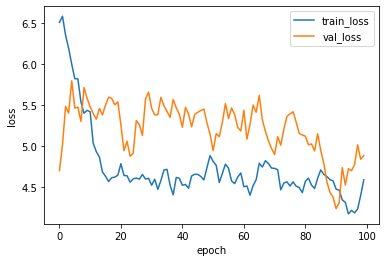

In [15]:
learning_curve(layer1.losses, layer1.val_losses, smoothing = True)

In [16]:
print(f"20까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all, y_train_all, epochs=20):.2f}")
print(f"40까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all, y_train_all, epochs=40):.2f}")
print(f"80까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all, y_train_all, epochs=80):.2f}")
print(f"88까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all, y_train_all, epochs=88):.2f}")
print(f"100까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all, y_train_all, epochs=100):.2f}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


20까지 epochs를 돌린 것 - 0.74
40까지 epochs를 돌린 것 - 0.75
80까지 epochs를 돌린 것 - 0.78
88까지 epochs를 돌린 것 - 0.81
100까지 epochs를 돌린 것 - 0.74


    learning curve를 통해 확인해보면 epochs가 90일때까지 val_loss가 떨어지고
    그 이후로는 증가하여 training_loss보다 계속 높은 것을 확인할 수 있다.
    그러므로 85까지 돌렸을때, 적합하게 훈련이 되었을 것이라 알 수 있다.
    
    100까지 cross_validation을 수행하여도 88에서 높은 수치가 나오는 것을 알 수 있다.
    100에포크를 넘어설때에도 비슷한 값을 도출할 수 있다. 계속하여 미니멈에 들어갔다가 나왔다가를 반복하기 때문이다.
    그러나, 효율성을 위해서 88에포크를 선택하였다.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


              precision    recall  f1-score   support

      Normal       0.76      0.65      0.70        20
    Abnormal       0.84      0.90      0.87        42

    accuracy                           0.82        62
   macro avg       0.80      0.78      0.79        62
weighted avg       0.82      0.82      0.82        62



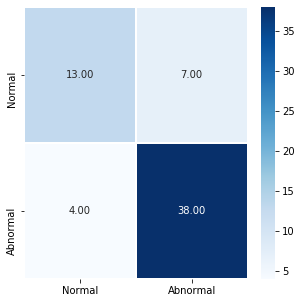

In [17]:
layer1 = SingleLayerNN()
layer1.fit(x_train, y_train, epochs=88, x_val=x_val, y_val=y_val)
visualize_matrix(y_test, layer1.predict(x_test))
ACCURACY_FOR_PLOT["BASELINE1"] = layer1.score(x_test, y_test)

    최종성능은 미리 빼둔 testset으로 도출할 것이다.
    모든 데이터셋에 대해서 동일하게 진행할 것이고,
    해당 베이스라인의 성능은 고로 82%이다.
    
    또한, abnormal을 abnormal로 분류하는 abnormal에 대한 재현율 역시 90으로 높다.
    즉, 질병이 있는 사람을 질병이 있다고 잘 분류해 낸다는 뜻이다.
    
    abnormal에 대한 recall - 실제 질병이 있는 사람들을 질병이라고 얼마나 잘 분류해내는지
    abnormal에 대한 precision - 질병이 있다고 분류한 사람들이 얼마나 실제로 질병인지
    의학관련한 지표에서는 abnormal에 대한 recall수치가 상대적으로 precision보다 중요하다.
    실제 질병이 있는 사람을 질병이라고 잘 분류해내야 하기 때문
    
    다른 에포크에 대해서도 실험해보았지만, 정확도는 1%정도 높아져도 recall이 많이 떨어짐

## BL1 - 번외.  초기값 세팅 관련 실험
    1. 가중치의 초기값을 1로 세팅
    2. 가중치의 초기값을 위에 적힌 방식대로 진행
    
    두개를 비교해볼 것입니다.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


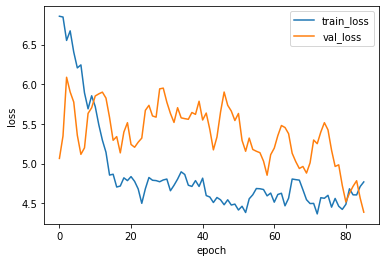

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


              precision    recall  f1-score   support

      Normal       0.71      0.60      0.65        20
    Abnormal       0.82      0.88      0.85        42

    accuracy                           0.79        62
   macro avg       0.76      0.74      0.75        62
weighted avg       0.78      0.79      0.79        62



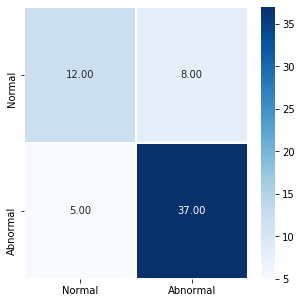

In [18]:
layer1 = SingleLayerNN()
layer1.fit(x_train, y_train, epochs=86, x_val=x_val, y_val=y_val, initialize= "Ones")
learning_curve(layer1.losses, layer1.val_losses, smoothing = True)
visualize_matrix(y_test, layer1.predict(x_test))
ACCURACY_FOR_PLOT["BASELINE1_extra"] = layer1.score(x_test, y_test)

    보시게 되면 초기값을 세팅해주지 않을 경우, BL1에서 수행한 결과보다 더 낮은 결과를 보인다는 것을 알 수 있습니다.
    learning_curve역시 적합하게 트레인 했다는 것을 보여주지만 더 낮은 성능을 보입니다.
    
    이렇게 초기값을 세팅해주는 것이 성능이 더 좋을 수 있는 이유는
    학습시에 임의의 값으로 인해서 학습이 잘 안되거나 가중치가 이상하게 튀어버리는 현상,
    err가 잘 계산되지 않는 현상 등이 발생할 수 있기 때문입니다.

## BL2 - minmax를 사용하여 정규화
    
    아래의 과정은 scaling을 통하여 정규화를 하여 성능을 올리고자한 시도입니다.
    각 피처들은 보시는 바와 같이 범위가 다릅니다.
    
    그러므로 이 피처들의 범위를 맞춰주기 위해서 정규화를 진행했습니다.
    첫번째 정규화 방법은 minmax 스케일러로 제일 큰 값을 1, 작은값을 0으로 정규화한 것입니다.
    
    또한, train을 정규화할 때 사용한 mean과 std를 그대로 사용해주었습니다.

In [19]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

# val_mean = np.mean(x_val, axis=0)
# val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - train_mean) / train_std

# test_mean = np.mean(x_test, axis=0)
# test_std = np.std(x_test, axis=0)
x_test_scaled = (x_test - train_mean) / train_std

# all_mean = np.mean(x_train_all, axis=0)
# all_std = np.std(x_train_all, axis=0)
x_train_all_scaled = (x_train_all - train_mean) / train_std

train features


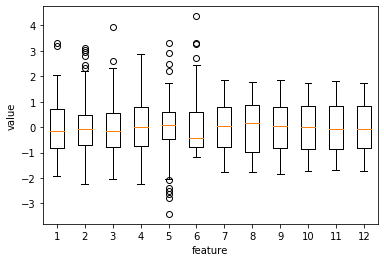

test features


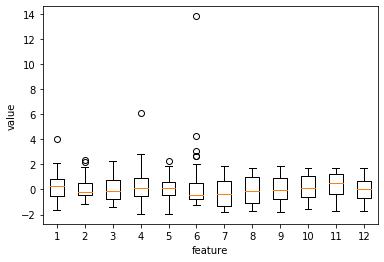

validation features


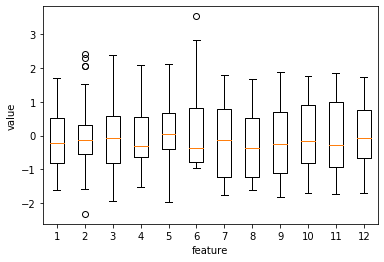

In [20]:
import matplotlib.pyplot as plt

print("train features")
plt.boxplot(x_train_scaled)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

print("test features")
plt.boxplot(x_test_scaled)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

print("validation features")
plt.boxplot(x_val_scaled)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

이전 플롯에 비해서 범위가 매우 안정화 된 것을 볼 수 있다.

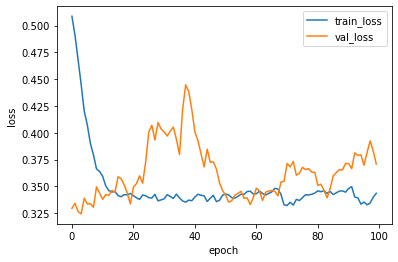

In [21]:
layer2 = SingleLayerNN()
layer2.fit(x_train_scaled, y_train, epochs=100, x_val=x_val_scaled, y_val=y_val)
learning_curve(layer2.losses, layer2.val_losses, smoothing = True)

    그래프는 19, 62, 82 부근에서 적절하게 피팅되는 것처럼 보인다.
    왜냐하면 그 이후에 val_loss그래프에 대해서 극소점이다. 또한, train_loss보다 낮아지는 지점이다.
    정확한 확인을 위해서 각 에포크에 대해서 cross-validation을 수행하였다.

In [22]:
print(f"19까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_scaled, y_train_all, epochs=19):.2f}")
print(f"40까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_scaled, y_train_all, epochs=40):.2f}")
print(f"62까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_scaled, y_train_all, epochs=62):.2f}")
print(f"82까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_scaled, y_train_all, epochs=82):.2f}")
print(f"100까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_scaled, y_train_all, epochs=100):.2f}")

19까지 epochs를 돌린 것 - 0.84
40까지 epochs를 돌린 것 - 0.84
62까지 epochs를 돌린 것 - 0.85
82까지 epochs를 돌린 것 - 0.85
100까지 epochs를 돌린 것 - 0.83


    스케일링을 해주니까, 스케일링이 없을 때보다 전반적으로 성능이 향상된 것을 볼 수 있다.
    
    높은 값이 62, 82 에포크로 학습하고 다시 테스트를 수행했다.

62 epochs
              precision    recall  f1-score   support

      Normal       0.67      0.80      0.73        20
    Abnormal       0.89      0.81      0.85        42

    accuracy                           0.81        62
   macro avg       0.78      0.80      0.79        62
weighted avg       0.82      0.81      0.81        62



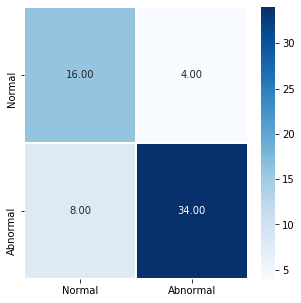

83 epochs
              precision    recall  f1-score   support

      Normal       0.83      0.75      0.79        20
    Abnormal       0.89      0.93      0.91        42

    accuracy                           0.87        62
   macro avg       0.86      0.84      0.85        62
weighted avg       0.87      0.87      0.87        62



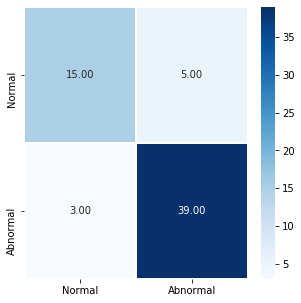

In [23]:
layer2 = SingleLayerNN()
print("62 epochs")
layer2.fit(x_train_scaled, y_train, epochs=62)
visualize_matrix(y_test, layer2.predict(x_test_scaled))

layer2 = SingleLayerNN()
print("83 epochs")
layer2.fit(x_train_scaled, y_train, epochs=82)
visualize_matrix(y_test, layer2.predict(x_test_scaled))
ACCURACY_FOR_PLOT["BASELINE2"] = layer2.score(x_test_scaled, y_test)

    82 에포크에 대해서 87%로 향상된 성능을 보여주었다.

## BL3 - StandardScaler
    다음은 StandardScaler를 사용해주었습니다.
    이는 개별 피처를 평균이 0이고 분산이 1이 되는 값으로 변환해줍니다.
    선형회귀는 데이터가 가우시안 분포를 가진다고 가정했기 때문에, 이를 활용한 ANN을 이용함으로
    가우시안 분포를 가지도록 개별피처를 변경해주는 StandardScaler를 사용하여 실험했습니다.

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_all_standard = scaler.fit_transform(x_train_all)
x_test_standard = scaler.transform(x_test)

In [35]:
x_train_standard, x_val_standard, y_train, y_val = train_test_split(x_train_all_standard, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=.2, 
                                                  random_state=1)

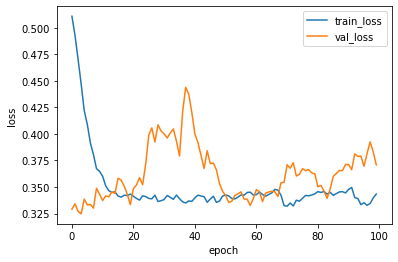

In [36]:
layer3 = SingleLayerNN()
layer3.fit(x_train_standard, y_train, epochs=100, x_val = x_val_standard, y_val = y_val)
learning_curve(layer3.losses, layer3.val_losses, smoothing = True)

    동일하게 그래프를 해석했을 때, minmax scaling한 것과 비슷하지만 조금씩의 차이가 발생하는 듯 했다.
    적당한 값을 보이는 듯한 19, 59, 82와 40, 100 의 값까지 합하여 cross-validation 실험을 진행하였다.

In [37]:
print(f"19까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=19):.2f}")
print(f"40까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=40):.2f}")
print(f"62까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=62):.2f}")
print(f"82까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=82):.2f}")
print(f"100까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=100):.2f}")

19까지 epochs를 돌린 것 - 0.84
40까지 epochs를 돌린 것 - 0.84
62까지 epochs를 돌린 것 - 0.85
82까지 epochs를 돌린 것 - 0.85
100까지 epochs를 돌린 것 - 0.84


    역시나 BL1보다 좋은 성능을 보여주었다.
    BL2와 매우 유사한 양상을 보이기 때문에, 82에포크만으로 다시 학습하여 testset을 적용하였다.

              precision    recall  f1-score   support

      Normal       0.83      0.75      0.79        20
    Abnormal       0.89      0.93      0.91        42

    accuracy                           0.87        62
   macro avg       0.86      0.84      0.85        62
weighted avg       0.87      0.87      0.87        62



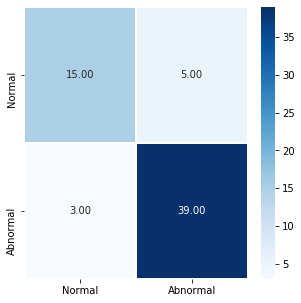

In [38]:
layer3 = SingleLayerNN()
layer3.fit(x_train_standard, y_train, epochs=82)
visualize_matrix(y_test, layer3.predict(x_test_standard))
ACCURACY_FOR_PLOT["BASELINE3"] = layer3.score(x_test_standard, y_test)

    BL2와 비슷하게 87%의 성능을 보였다.
    minmax와 standardscaling 두가지 모두 향상된 성능을 보인다
    
    현재까지
    BL1 - 82%
    BL2 - 87%
    BL3 - 87%
    이다.

## Pearson 상관계수 분석
    피어슨 상관계수를 통해서 Normal, Abnormal과 각 피처들의 관계를 파악해주었습니다.
    피어슨 상관 계수(Pearson Correlation Coefficient ,PCC)란 두 변수 X 와 Y 간의 선형 상관 관계를 계량화한 수치입니다. (위키피디아)
    0과 1이기 때문에 피어슨 상관계수를 완벽하게 분석할 수는 없습니다.
    
    그러나 P값도 낮고, 상관도도 높은 것에 대해서 그래프를 분석해보고자 하였습니다.

In [39]:
y = np.where(np.array(df.Class_att.tolist())=="Normal", 0, 1) # 0과 1로 변경하고 상관관계를 파악하고자 하였다.
import scipy.stats as stats
for i in range(1, 13):
    corr = stats.pearsonr(y, df[f"Col{i}"])
    print(f"Col{i} -> 피어슨 유사도: {corr[0]:.2f}, 유의미한 p: {corr[1]:.3f}")

Col1 -> 피어슨 유사도: 0.35, 유의미한 p: 0.000
Col2 -> 피어슨 유사도: 0.33, 유의미한 p: 0.000
Col3 -> 피어슨 유사도: 0.31, 유의미한 p: 0.000
Col4 -> 피어슨 유사도: 0.21, 유의미한 p: 0.000
Col5 -> 피어슨 유사도: -0.31, 유의미한 p: 0.000
Col6 -> 피어슨 유사도: 0.44, 유의미한 p: 0.000
Col7 -> 피어슨 유사도: 0.06, 유의미한 p: 0.327
Col8 -> 피어슨 유사도: -0.04, 유의미한 p: 0.487
Col9 -> 피어슨 유사도: -0.05, 유의미한 p: 0.387
Col10 -> 피어슨 유사도: 0.10, 유의미한 p: 0.079
Col11 -> 피어슨 유사도: 0.03, 유의미한 p: 0.637
Col12 -> 피어슨 유사도: -0.07, 유의미한 p: 0.224


유사도가 높고 p값이 낮은 Col1과 Col6를 가지고 그래프를 찍고, 관계가 낮은 Col7, Col11을 찍어보았습니다.

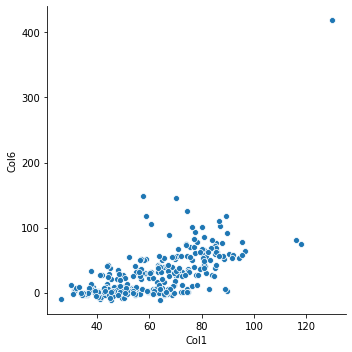

In [40]:
sns.relplot(x="Col1", y="Col6", data=df)

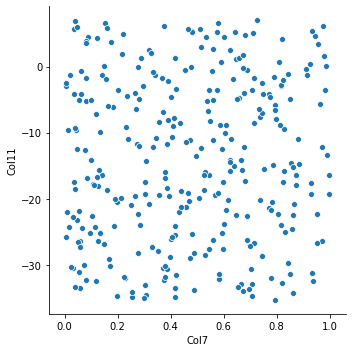

In [41]:
sns.relplot(x="Col7", y="Col11", data=df)

    놀랍게도 관계가 높은 피처들끼리는 어느정도 선형관계를 보이지만, 관계가 없는 피처끼리는 관계가 없는 것처럼 보이게 됩니다.
    그러므로, 피처들 중에서 label과 피어슨 상관계수가 작은 피처들을 제거해주고 다시 학습하였습니다.
    
    성능이 높았던 BL3를 기반으로 위의 사항을 적용하였습니다.

In [42]:
X = np.array(df.drop(["Class_att", "Col11","Col12","Col7","Col8","Col9"], axis=1))

In [43]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(X, y, stratify=y, 
                                                            test_size=.2, 
                                                            random_state=1)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_all_standard = scaler.fit_transform(x_train_all)
x_test_standard = scaler.transform(x_test)

In [45]:
x_train_standard, x_val_standard, y_train, y_val = train_test_split(x_train_all_standard, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=.2, 
                                                  random_state=1)

In [46]:
layer4 = SingleLayerNN()
layer4.fit(x_train_standard, y_train, epochs=100, x_val=x_val_standard, y_val=y_val)
print(layer4.score(x_val_standard, y_val))

0.88


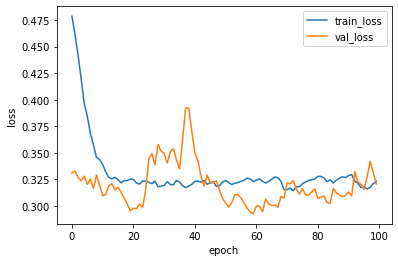

In [47]:
learning_curve(layer4.losses, layer4.val_losses, smoothing = True)

In [48]:
print(f"20까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=20):.2f}")
print(f"62까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=62):.2f}")
print(f"82까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=82):.2f}")
print(f"88까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=88):.2f}")
print(f"100까지 epochs를 돌린 것 - {myfunc_cross_validation(SingleLayerNN, x_train_all_standard, y_train_all, epochs=100):.2f}")

20까지 epochs를 돌린 것 - 0.84
62까지 epochs를 돌린 것 - 0.85
82까지 epochs를 돌린 것 - 0.85
88까지 epochs를 돌린 것 - 0.86
100까지 epochs를 돌린 것 - 0.86


              precision    recall  f1-score   support

      Normal       0.71      0.85      0.77        20
    Abnormal       0.92      0.83      0.88        42

    accuracy                           0.84        62
   macro avg       0.81      0.84      0.82        62
weighted avg       0.85      0.84      0.84        62



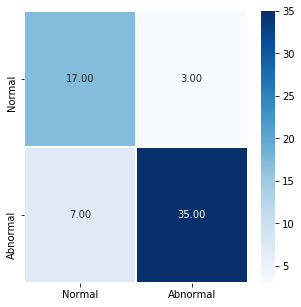

              precision    recall  f1-score   support

      Normal       0.71      0.85      0.77        20
    Abnormal       0.92      0.83      0.88        42

    accuracy                           0.84        62
   macro avg       0.81      0.84      0.82        62
weighted avg       0.85      0.84      0.84        62



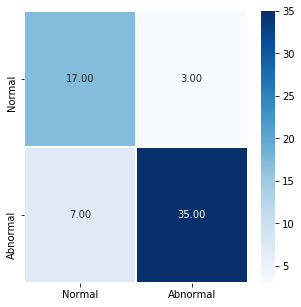

In [61]:
layer4 = SingleLayerNN()
layer4.fit(x_train_standard, y_train, epochs=88)
visualize_matrix(y_test, layer4.predict(x_test_standard))

layer4 = SingleLayerNN()
layer4.fit(x_train_standard, y_train, epochs=100)
visualize_matrix(y_test, layer4.predict(x_test_standard))

ACCURACY_FOR_PLOT["BASELINE4"] = layer4.score(x_test_standard, y_test)

    동일한 이유로 88, 100 에포크를 학습시키고 테스트셋을 넣어주었다.
    물론 성능은 BL3에 비해서 떨어진 것을 알 수 있다.
    BL2,3 에서는 에포크에 따라 여러가지 테스트를 해보았을 때, 성능의 차이가 많이 발생하였다.
    그러나 BL4의 경우, 테스트를 위해 여러가지 테스트셋을 넣어보았는데,
    여러가지 에포크에 따라서 테스트셋의 성능차이가 심하게 발생하지 않았다.
    
    피처값의 이상치나 Normal, Abnormal을 결정짓는데 큰 작용을 하지 않는 값이 빠져서
    적은 에포크수로도 큰 무리없이 학습이 되었다고 생각해볼 수 있다.

## BL5 testing l1, l2 normalization
    성능이 좋은 Baseline3에 대해서 l1, l2 정규화에 대한 테스트를 진행하려고 하였다.
    정규화는 가중치가 너무 데이터에 fit해지는 것을 막아서 일반적이게 되도록 하는 것이다.
    이로 인한 장점은 오버피팅을 막아준다는 장점이 있다.
    
    그러나 l1, l2에 넣는 파라미터가 너무 커지게 되면 학습이 제대로 이뤄지지 않는 경우가 발생할 수 있어서 적절한 벨런스가 중요하다.
    적절한 벨런스를 맞출 경우, 새로운 데이터인 test데이터에 대해서도 비교적 높은 성능을 얻을 수 있다.
    테스트는 다음과 같은 방식으로 진행된다.
    
    l1 = [0.00001, 0.001, 0.01, 0.1]
    l2 = [0.00001, 0.001, 0.01, 0.1]
    
    이 두가지를 적용하여 어떻게 학습이 이뤄지는지 러닝커브와 가중치를 확인해볼 것이다.
    확인하여 분석한 결과를 바탕으로 새로운 데이터인 testset에 대해서 테스트해볼 예정이다.

In [62]:
def draw_weight(lyr, name):
    import matplotlib.pyplot as plt
    plt.plot(lyr.w, 'bo')
    plt.title(name)
    plt.xlabel('weight')
    plt.ylabel('value')
    plt.ylim(-10, 10)
    plt.show()

In [63]:
# X를 정상과 비정상을 제외한 값들로 설정해주었고,
# y를 Normal은 0, Abnormal을 1로 설정함
# 이전 실험에서 X에 대해서 누락시킨 feature가 존재하여 해당 피처를 복원하여 다시 수행하였다.
X = np.array(df.drop(["Class_att"], axis=1))
y = np.where(np.array(df.Class_att.tolist())=="Normal", 0, 1)

In [64]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(X, y, stratify=y, 
                                                            test_size=.2, 
                                                            random_state=1)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_all_standard = scaler.fit_transform(x_train_all)
x_test_standard = scaler.transform(x_test)

In [66]:
x_train_standard, x_val_standard, y_train, y_val = train_test_split(x_train_all_standard, y_train_all, 
                                                  stratify=y_train_all, 
                                                  test_size=.2, 
                                                  random_state=1)

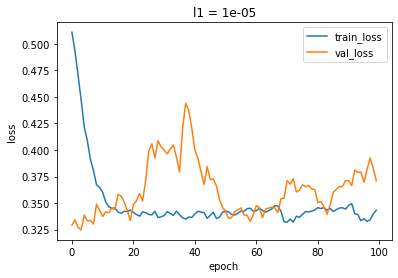

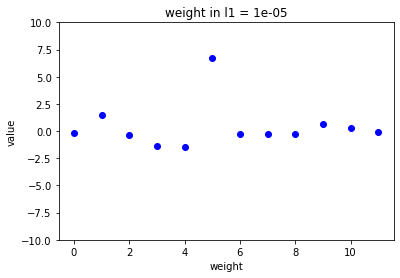

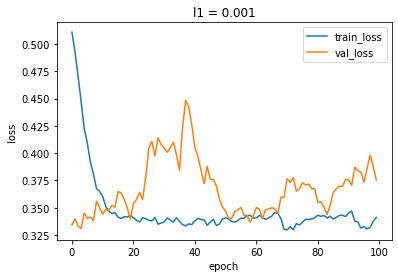

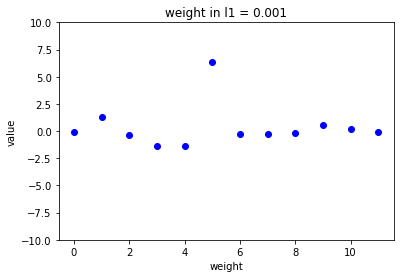

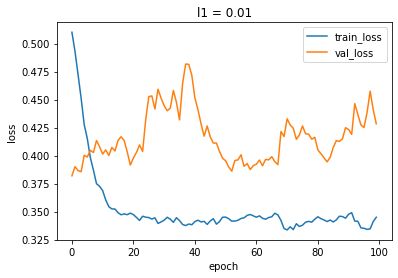

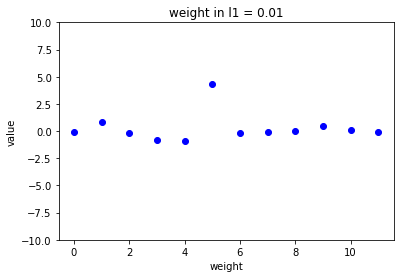

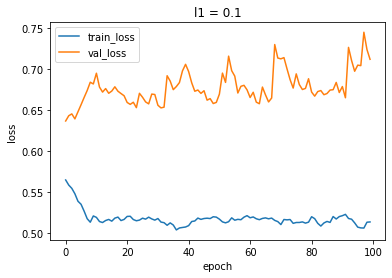

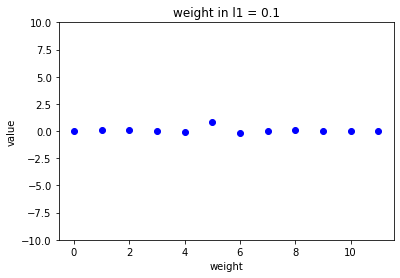

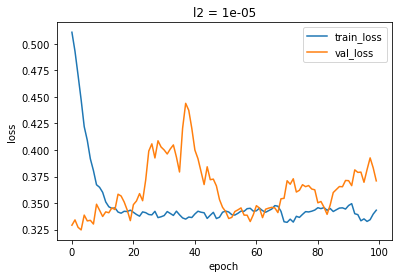

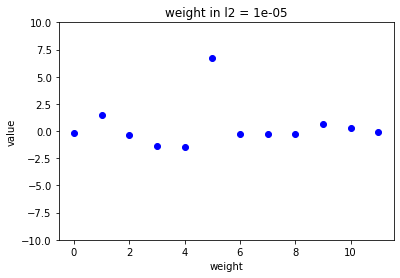

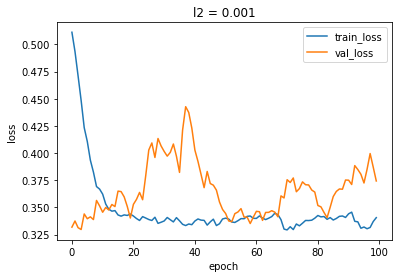

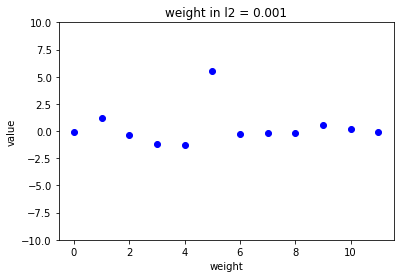

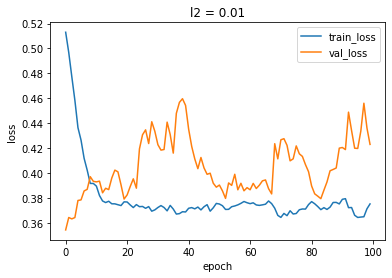

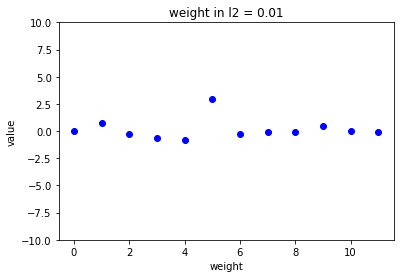

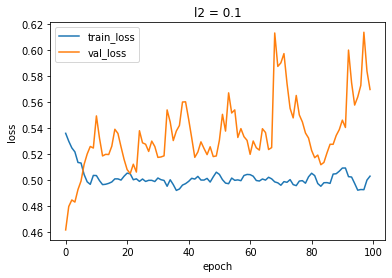

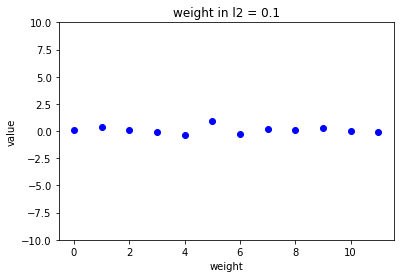

In [67]:
l_list = [0.00001, 0.001, 0.01, 0.1]

for l1 in l_list:
    layer5 = SingleLayerNN(l1 = l1)
    layer5.fit(x_train_standard, y_train, epochs=100, x_val = x_val_standard, y_val = y_val)
    learning_curve(layer5.losses, layer5.val_losses, smoothing = True, name = f"l1 = {l1}")
    draw_weight(layer5, name= f"weight in l1 = {l1}")
for l2 in l_list:
    layer5 = SingleLayerNN(l2 = l2)
    layer5.fit(x_train_standard, y_train, epochs=100, x_val = x_val_standard, y_val = y_val)
    learning_curve(layer5.losses, layer5.val_losses, smoothing = True, name = f"l2 = {l2}") 
    draw_weight(layer5, name= f"weight in l2 = {l2}")

    수업시간에 배운대로, l1, l2가 늘어날수록 weight가 적게 학습되는 것을 확인할 수 있다.
    0.00001보다 0.1에서 weight가 0과 가까이에 고르게 찍힌 것을 알 수 있다.
    learning curve를 보게 되면, validation_loss가 높게 나오는 것을 알 수 있다.
    어쩔 수 없이 regulization해준 만큼 loss가 상승한다.
    
    weight가 찍힌걸 보니 l1의 경우 0.1에 weight가 가까워질 수록 val_loss가 너무 큰폭으로 증가하는 것을 알 수 있다.
    l2는 비교적 val_loss가 0.1에 가까워 져도 큰 폭으로 상승하지는 않는 것을 볼 수 있다.
    0.001, 0.01이 비교적 loss를 올리지 않으면서도 weight를 높게 잡을 수 있는 것 같아 두가지의 파라미터를 선정하였다.
    0.1의 경우 weight가 너무 0에 가까워서 그보다 weight가 작은 0.001, 0.01을 선정하였다.
  
    이 두가지 파라미터를 가지고 처음보는 데이터인 test에 넣어보도록 할 것이다.

l2 = 0.01
              precision    recall  f1-score   support

      Normal       0.93      0.70      0.80        20
    Abnormal       0.87      0.98      0.92        42

    accuracy                           0.89        62
   macro avg       0.90      0.84      0.86        62
weighted avg       0.89      0.89      0.88        62



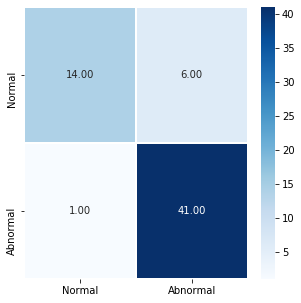

l2 = 0.001
              precision    recall  f1-score   support

      Normal       0.83      0.75      0.79        20
    Abnormal       0.89      0.93      0.91        42

    accuracy                           0.87        62
   macro avg       0.86      0.84      0.85        62
weighted avg       0.87      0.87      0.87        62



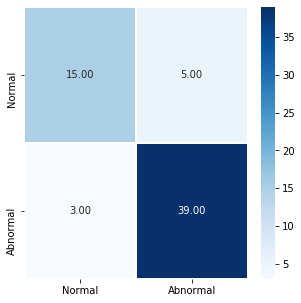

In [68]:
layer5 = SingleLayerNN(l2 = 0.01)
print("l2 = 0.01")
layer5.fit(x_train_standard, y_train, epochs=82)
visualize_matrix(y_test, layer5.predict(x_test_standard))

ACCURACY_FOR_PLOT["BASELINE5"] = layer5.score(x_test_standard, y_test)

layer5 = SingleLayerNN(l2 = 0.001)
print("l2 = 0.001")
layer5.fit(x_train_standard, y_train, epochs=82)
visualize_matrix(y_test, layer5.predict(x_test_standard))

    보시다시피, 0.01에서 새로운 데이터인 test를 높은 성능으로 맞춘 다는 것을 볼 수 있다.
    특히 abnormal의 recall에 대해서 0.98의 성능을 보이고, 정확도는 0.89까지 상승하였다.

In [111]:
score_df = pd.DataFrame(ACCURACY_FOR_PLOT, index = [0]) * 100

Text(0.5, 0, 'Baselines')

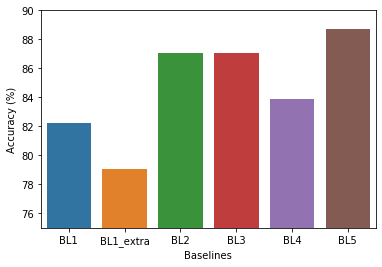

In [115]:
sns.barplot(data=score_df)
plt.xticks(np.arange(6), 
           ("BL1","BL1_extra","BL2","BL3","BL4","BL5"
           ))
plt.ylabel('Accuracy (%)')
plt.ylim(75, 90)
plt.xlabel('Baselines')

# 결론
    문제 정의에서 이야기한 "허리통증의 심각성"과 관련한 문제를 해결하기 위해 여러가지 피처를 활용하여 예측하였고, 더 정확한 예측을 위하여 성능을 향상시킬 수 있는 여러가지 기법을 적용하였습니다.
    
    결론적으로 제일 성능이 좋은 모델에서 테스트셋에 대하여 89%의 성능을 보였습니다.
    위에서 보시는 바와 같이 수업시간중 진행한 SingleLayerNN과 아무런 처리 없이 수행한 데이터셋으로 test세트에 대해서 수행한 결과가 0.79였습니다(BL1-번외 실험). 그것과 비교하였을 때, 다양한 기법을 활용하여 10%의 성능을 향상시켰습니다.
    
    실제로 병원에 환자가 방문하였을 때, 환자를 환자로 분류해내는 성능인 Abnormal에 대한 recall역시 제일 좋은 모델에 대하여 98%의 성능을 얻었습니다.